<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/Etv2_motifs_in_early_Etv2_peaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examine proportion of early, late and sustained Etv2 peaks having canonical Etv2 motifs.
by Wuming Gong



Current analysis showed that there are a large proportion `early` Etv2 peaks that are present in D1 post induction and disappear during the reprogramming.  Most of these early peaks may be due to the random `scanning` events, that are not associated with particular epigenetic environment or motif pattern.  This notebook is to examine the features of early peaks.

In [120]:
start_time0 <- Sys.time()
options(max.print=1000)

### Install external packages

In [121]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                       
[2] "Building dependency tree..."                                    
[3] "Reading state information..."                                   
[4] "libgsl-dev is already the newest version (2.4+dfsg-6)."         
[5] "0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded."

In [122]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                         
[2] "Building dependency tree..."                                      
[3] "Reading state information..."                                     
[4] "libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1)."
[5] "0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded."

## Install R packages

In [123]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [124]:
required_packages <- c(
  'devtools', 'BiocManager', 
  'circlize',
  'GenomicRanges', 'rtracklayer', 'EnrichedHeatmap', 'BSgenome.Mmusculus.UCSC.mm10', 'EnrichedHeatmap',
  'gsl', 'DirichletMultinomial', 'motifmatchr', 'chromVAR', 'PWMEnrich', 'ggseqlogo'
)

In [125]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [126]:
library(devtools)

### Install R packages that are not available on CRAN or Bioc

In [127]:
if (!require('chromVARmotifs'))
  devtools::install_github("GreenleafLab/chromVARmotifs")

In [128]:
if (!require('ComplexHeatmap'))
  devtools::install_github("jokergoo/ComplexHeatmap")

## Load R packages

In [129]:
library(GenomicRanges)
library(dplyr)
library(BSgenome.Mmusculus.UCSC.mm10)
library(motifmatchr)
library(chromVARmotifs)
library(SummarizedExperiment)
library(ggplot2)
library(ComplexHeatmap)
library(EnrichedHeatmap)
library(circlize) # colorRamp2
library(ggseqlogo)

## Read a combined Etv2 ChIP-seq peak set

In [130]:
all_etv2_peaks_url <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds'
gr <- all_etv2_peaks_url %>%
  url() %>%
  gzcon() %>%
  readRDS()
gr
colnames(gr$group)

GRanges object with 162010 ranges and 4 metadata columns:
           seqnames            ranges strand |                peak_id     score
              <Rle>         <IRanges>  <Rle> |            <character> <numeric>
       [1]     chr1   3037784-3037983      * | /panfs/roc/scratch/g..  16.22768
       [2]     chr1   3263790-3263989      * | /panfs/roc/scratch/g..   8.36521
       [3]     chr1   3344682-3344881      * | /panfs/roc/scratch/g..   9.73217
       [4]     chr1   3460640-3460839      * | /panfs/roc/scratch/g..   3.92081
       [5]     chr1   3490314-3490513      * | /panfs/roc/scratch/g..  12.29730
       ...      ...               ...    ... .                    ...       ...
  [162006]     chrY 90828936-90829135      * | /panfs/roc/scratch/g.. 160.15463
  [162007]     chrY 90836259-90836458      * | /panfs/roc/scratch/g..   8.27339
  [162008]     chrY 90841624-90841823      * | /panfs/roc/scratch/g..   1.53792
  [162009]     chrY 90842563-90842762      * | /panfs/roc/scra

[1] "MEF_Dox_d1_Etv2" "MEF_Dox_d2_Etv2" "MEF_Dox_d7_Etv2" "EB_Dox_3h_Etv2" 
[5] "EB_Dox_12h_Etv2"

## Split the Etv2 MEF peaks into three groups
1. on at D1 and off at D7 (early)
2. off at D1 and on at D7 (late)
3. on at both D1 and D7 (sustained)

In [131]:
peaks_MEF <- gr[gr$group[, 'MEF_Dox_d1_Etv2'] | gr$group[, 'MEF_Dox_d7_Etv2']]
message(sprintf('number of early peaks: %d\n', sum(peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & !peaks_MEF$group[, 'MEF_Dox_d7_Etv2'])))
message(sprintf('number of late peaks: %d\n', sum(!peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF$group[, 'MEF_Dox_d7_Etv2'])))
message(sprintf('number of sustained peaks: %d\n', sum(peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF$group[, 'MEF_Dox_d7_Etv2'])))

number of early peaks: 111167


number of late peaks: 4222


number of sustained peaks: 12170




### Split the Etv2 ES/SB peaks into three groups
1. on at 3h and off at 12h (early)
2. off at 3h and on at 12h (late)
3. on at both 3h and 12h (sustained)


In [132]:
peaks_EB <- gr[gr$group[, 'EB_Dox_3h_Etv2'] | gr$group[, 'EB_Dox_12h_Etv2']]
cat(sprintf('number of early peaks: %d\n', sum(peaks_EB$group[, 'EB_Dox_3h_Etv2'] & !peaks_EB$group[, 'EB_Dox_12h_Etv2'])))
cat(sprintf('number of late peaks: %d\n', sum(!peaks_EB$group[, 'EB_Dox_3h_Etv2'] & peaks_EB$group[, 'EB_Dox_12h_Etv2'])))
cat(sprintf('number of sustained peaks: %d\n', sum(peaks_EB$group[, 'EB_Dox_3h_Etv2'] & peaks_EB$group[, 'EB_Dox_12h_Etv2'])))

number of early peaks: 8488
number of late peaks: 3356
number of sustained peaks: 7807


## Load motifs

In [133]:
data('homer_pwms')

In [134]:
Etv2_canonical <- homer_pwms[['Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967)']]
Etv2_canonical

An object of class PWMatrix
ID: Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967)
Name: Etv2(ETS)
Matrix Class: Unknown
strand: +
Pseudocounts: 
Tags: 
$evidence
[1] "ES-ER71-ChIP-Seq(GSE59402)"

$source
[1] "Homer(0.967)"

Background: 
   A    C    G    T 
0.25 0.25 0.25 0.25 
Matrix: 
         [,1]       [,2]        [,3]       [,4]        [,5]      [,6]      [,7]
A -0.16016875 -0.3856625  0.60758929 -2.3859667  0.08801088 -5.521461 -5.521461
C  0.18564935  0.1988509 -0.60880603  0.6418539 -5.52146092 -5.521461  1.383290
G  0.02371653 -0.0618754  0.06203539 -0.9571127 -2.74887220 -5.521461 -5.521461
T -0.08338161  0.1484200 -0.58698698  0.4848922  1.04380405  1.383290 -5.521461
       [,8]       [,9]       [,10]      [,11]       [,12]
A -5.521461 -2.4304185 -1.53247687 -0.1544844 -0.46621461
C  1.383290 -2.4304185 -0.03666398  0.1071607  0.09066769
G -5.521461  0.4134333  0.69912925 -0.3787969  0.09431068
T -5.521461  0.8381130 -0.21319322  0.2966507  0.16451494

In [135]:
Etv2_partial <- reverseComplement(Etv2_canonical)
Etv2_partial@profileMatrix <- Etv2_partial@profileMatrix[, 1:8]
Etv2_partial@ID <- 'Etv2(ETS)/Partial'
Etv2_partial

An object of class PWMatrix
ID: Etv2(ETS)/Partial
Name: Etv2(ETS)
Matrix Class: Unknown
strand: -
Pseudocounts: 
Tags: 
$evidence
[1] "ES-ER71-ChIP-Seq(GSE59402)"

$source
[1] "Homer(0.967)"

Background: 
   A    C    G    T 
0.25 0.25 0.25 0.25 
Matrix: 
         [,1]       [,2]        [,3]       [,4]      [,5]      [,6]      [,7]
A  0.16451494  0.2966507 -0.21319322  0.8381130 -5.521461 -5.521461  1.383290
C  0.09431068 -0.3787969  0.69912925  0.4134333 -5.521461 -5.521461 -5.521461
G  0.09066769  0.1071607 -0.03666398 -2.4304185  1.383290  1.383290 -5.521461
T -0.46621461 -0.1544844 -1.53247687 -2.4304185 -5.521461 -5.521461 -5.521461
         [,8]
A  1.04380405
C -2.74887220
G -5.52146092
T  0.08801088

## Find motif binding sites

In [136]:
cutoff <- 5e-4
width <- 50L

In [137]:
motif_ix <- matchMotifs(
  as(list(Etv2_canonical, Etv2_partial), 'SimpleList'), 
  resize(peaks_MEF, width = width, fix = 'center'), 
  genome = BSgenome.Mmusculus.UCSC.mm10,
  p.cutoff = cutoff
)
has_motif_MEF  <- assays(motif_ix)$motifMatches
colnames(has_motif_MEF) <- c('canonical', 'partial')

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [138]:
motif_ix <- matchMotifs(
  as(list(Etv2_canonical, Etv2_partial), 'SimpleList'), 
  resize(peaks_EB, width = width, fix = 'center'), 
  genome = BSgenome.Mmusculus.UCSC.mm10,
  p.cutoff = cutoff
)
has_motif_EB  <- assays(motif_ix)$motifMatches
colnames(has_motif_EB) <- c('canonical', 'partial')

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [139]:
d <- rbind(
  data.frame(
    n = sum(peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & !peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    type = 'early',
    n_Etv2 = sum(has_motif_MEF[, 'canonical'] & peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & !peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    motif = 'canonical',
    celltype = 'MEF'
  ),
  data.frame(
    n = sum(peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    type = 'sustained',
    n_Etv2 = sum(has_motif_MEF[, 'canonical'] & peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    motif = 'canonical',
    celltype = 'MEF'
  ),
  data.frame(
    n = sum(!peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    type = 'late',
    n_Etv2 = sum(has_motif_MEF[, 'canonical'] & !peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    motif = 'canonical',
    celltype = 'MEF'
  ),
  data.frame(
    n = sum(peaks_EB$group[, 'EB_Dox_3h_Etv2'] & !peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    type = 'early',
    n_Etv2 = sum(has_motif_EB[, 'canonical'] & peaks_EB$group[, 'EB_Dox_3h_Etv2'] & !peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    motif = 'canonical',
    celltype = 'EB'
  ),
  data.frame(
    n = sum(peaks_EB$group[, 'EB_Dox_3h_Etv2'] & peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    type = 'sustained',
    n_Etv2 = sum(has_motif_EB[, 'canonical'] & peaks_EB$group[, 'EB_Dox_3h_Etv2'] & peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    motif = 'canonical',
    celltype = 'EB'
  ),
  data.frame(
    n = sum(!peaks_EB$group[, 'EB_Dox_3h_Etv2'] & peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    type = 'late',
    n_Etv2 = sum(has_motif_EB[, 'canonical'] & !peaks_EB$group[, 'EB_Dox_3h_Etv2'] & peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    motif = 'canonical',
    celltype = 'EB'
  ),
  data.frame(
    n = sum(peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & !peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    type = 'early',
    n_Etv2 = sum(has_motif_MEF[, 'partial'] & peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & !peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    motif = 'partial',
    celltype = 'MEF'
  ),
  data.frame(
    n = sum(peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    type = 'sustained',
    n_Etv2 = sum(has_motif_MEF[, 'partial'] & peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    motif = 'partial',
    celltype = 'MEF'
  ),
  data.frame(
    n = sum(!peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    type = 'late',
    n_Etv2 = sum(has_motif_MEF[, 'partial'] & !peaks_MEF$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF$group[, 'MEF_Dox_d7_Etv2']),
    motif = 'partial',
    celltype = 'MEF'
  ),
  data.frame(
    n = sum(peaks_EB$group[, 'EB_Dox_3h_Etv2'] & !peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    type = 'early',
    n_Etv2 = sum(has_motif_EB[, 'partial'] & peaks_EB$group[, 'EB_Dox_3h_Etv2'] & !peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    motif = 'partial',
    celltype = 'EB'
  ),
  data.frame(
    n = sum(peaks_EB$group[, 'EB_Dox_3h_Etv2'] & peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    type = 'sustained',
    n_Etv2 = sum(has_motif_EB[, 'partial'] & peaks_EB$group[, 'EB_Dox_3h_Etv2'] & peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    motif = 'partial',
    celltype = 'EB'
  ),
  data.frame(
    n = sum(!peaks_EB$group[, 'EB_Dox_3h_Etv2'] & peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    type = 'late',
    n_Etv2 = sum(has_motif_EB[, 'partial'] & !peaks_EB$group[, 'EB_Dox_3h_Etv2'] & peaks_EB$group[, 'EB_Dox_12h_Etv2']),
    motif = 'partial',
    celltype = 'EB'
  )

)
d

n,type,n_Etv2,motif,celltype
<int>,<chr>,<int>,<chr>,<chr>
111167,early,14074,canonical,MEF
12170,sustained,4965,canonical,MEF
4222,late,2304,canonical,MEF
8488,early,3058,canonical,EB
7807,sustained,4470,canonical,EB
3356,late,1962,canonical,EB
111167,early,12287,partial,MEF
12170,sustained,4239,partial,MEF
4222,late,2043,partial,MEF


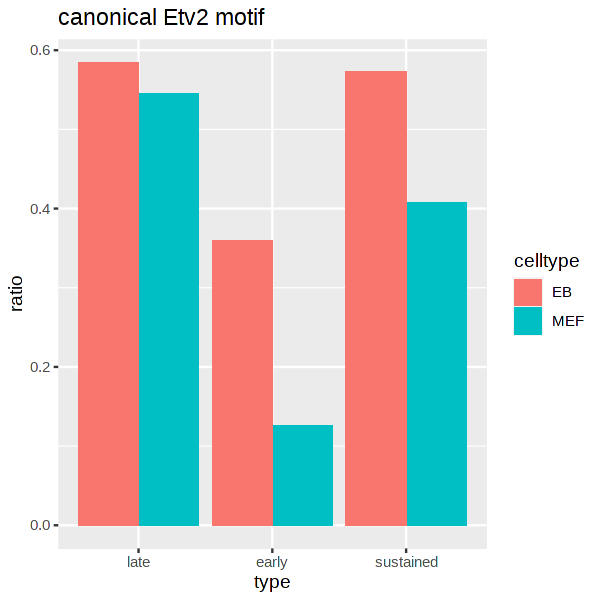

In [140]:
options(repr.plot.width = 5, repr.plot.height = 5)
d %>% 
  mutate(ratio = n_Etv2 / n) %>%
  filter(motif == 'canonical') %>%
  mutate(type = factor(type, c('late', 'early', 'sustained'))) %>% 
  ggplot(aes(x = type, y = ratio, fill = celltype)) +
    geom_bar(stat="identity", position=position_dodge()) +
    ggtitle('canonical Etv2 motif')

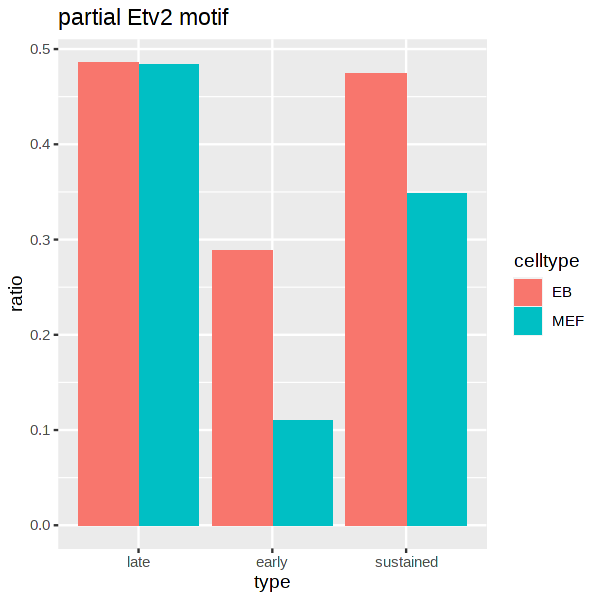

In [141]:
options(repr.plot.width = 5, repr.plot.height = 5)
d %>% 
  mutate(ratio = n_Etv2 / n) %>%
  filter(motif == 'partial') %>%
  mutate(type = factor(type, c('late', 'early', 'sustained'))) %>% 
  ggplot(aes(x = type, y = ratio, fill = celltype)) +
    geom_bar(stat="identity", position=position_dodge()) +
    ggtitle('partial Etv2 motif')

A significantly larger proportion of early peaks in EB has Etv2 motifs than early peaks in MEF.  This suggested that in EB, the Etv2 is less likely to be trapped by some random sites.

## Examine the distribution of Etv2 motifs for each binding group

In [142]:
width <- 501
peaks_MEF2 <- resize(peaks_MEF, fix = 'center', width = width)

In [143]:
binding_sites <- matchMotifs(
  as(list(Etv2_canonical, Etv2_partial), 'SimpleList'), 
  resize(peaks_MEF2, width = 2 * width, fix = 'center'),
  genome = BSgenome.Mmusculus.UCSC.mm10,
  p.cutoff = cutoff,
  out = 'positions'
)
names(binding_sites) <- c('canonical', 'partial')

In [144]:
seqlevels(binding_sites) <- seqlevels(BSgenome.Mmusculus.UCSC.mm10)
seqlengths(seqinfo(binding_sites)) <- seqlengths(BSgenome.Mmusculus.UCSC.mm10)
genome(seqinfo(binding_sites)) <- providerVersion(BSgenome.Mmusculus.UCSC.mm10)

Warning message:
“  Using providerVersion() on a BSgenome object is deprecated. Please use
  'metadata(x)$genome' instead.”


In [145]:
cvg_canonical <- coverage(binding_sites[['canonical']], weight = 'score')
cvg_partial <- coverage(binding_sites[['partial']], weight = 'score')

In [146]:
pos <- 1:width - (width + 1)/2

In [147]:
df_MEF <- rbind(
  data.frame(
    position = pos,
    density = cvg_canonical[peaks_MEF2[peaks_MEF2$group[, 'MEF_Dox_d1_Etv2'] & !peaks_MEF2$group[, 'MEF_Dox_d7_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'canonical',
    group = 'early'
  ),
  data.frame(
    position = pos,
    density = cvg_canonical[peaks_MEF2[!peaks_MEF2$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF2$group[, 'MEF_Dox_d7_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'canonical',
    group = 'late'
  ),
  data.frame(
    position = pos,
    density = cvg_canonical[peaks_MEF2[peaks_MEF2$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF2$group[, 'MEF_Dox_d7_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'canonical',
    group = 'sustained'
  ),
  data.frame(
    position = pos,
    density = cvg_partial[peaks_MEF2[peaks_MEF2$group[, 'MEF_Dox_d1_Etv2'] & !peaks_MEF2$group[, 'MEF_Dox_d7_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'partial',
    group = 'early'
  ),
  data.frame(
    position = pos,
    density = cvg_partial[peaks_MEF2[!peaks_MEF2$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF2$group[, 'MEF_Dox_d7_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'partial',
    group = 'late'
  ),
  data.frame(
    position = pos,
    density = cvg_partial[peaks_MEF2[peaks_MEF2$group[, 'MEF_Dox_d1_Etv2'] & peaks_MEF2$group[, 'MEF_Dox_d7_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'partial',
    group = 'sustained'
  )
)

In [148]:
peaks_EB2 <- resize(peaks_EB, fix = 'center', width = width)

In [149]:
binding_sites <- matchMotifs(
  as(list(Etv2_canonical, Etv2_partial), 'SimpleList'), 
  resize(peaks_EB2, width = 2 * width, fix = 'center'),
  genome = BSgenome.Mmusculus.UCSC.mm10,
  p.cutoff = cutoff,
  out = 'positions'
)
names(binding_sites) <- c('canonical', 'partial')

In [150]:
seqlevels(binding_sites) <- seqlevels(BSgenome.Mmusculus.UCSC.mm10)
seqlengths(seqinfo(binding_sites)) <- seqlengths(BSgenome.Mmusculus.UCSC.mm10)
genome(seqinfo(binding_sites)) <- providerVersion(BSgenome.Mmusculus.UCSC.mm10)

Warning message:
“  Using providerVersion() on a BSgenome object is deprecated. Please use
  'metadata(x)$genome' instead.”


In [151]:
cvg_canonical <- coverage(binding_sites[['canonical']], weight = 'score')
cvg_partial <- coverage(binding_sites[['partial']], weight = 'score')

In [152]:
df_EB <- rbind(
  data.frame(
    position = pos,
    density = cvg_canonical[peaks_EB2[peaks_EB2$group[, 'EB_Dox_3h_Etv2'] & !peaks_EB2$group[, 'EB_Dox_12h_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'canonical',
    group = 'early'
  ),
  data.frame(
    position = pos,
    density = cvg_canonical[peaks_EB2[!peaks_EB2$group[, 'EB_Dox_3h_Etv2'] & peaks_EB2$group[, 'EB_Dox_12h_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'canonical',
    group = 'late'
  ),
  data.frame(
    position = pos,
    density = cvg_canonical[peaks_EB2[peaks_EB2$group[, 'EB_Dox_3h_Etv2'] & peaks_EB2$group[, 'EB_Dox_12h_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'canonical',
    group = 'sustained'
  ),
  data.frame(
    position = pos,
    density = cvg_partial[peaks_EB2[peaks_EB2$group[, 'EB_Dox_3h_Etv2'] & !peaks_EB2$group[, 'EB_Dox_12h_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'partial',
    group = 'early'
  ),
  data.frame(
    position = pos,
    density = cvg_partial[peaks_EB2[!peaks_EB2$group[, 'EB_Dox_3h_Etv2'] & peaks_EB2$group[, 'EB_Dox_12h_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'partial',
    group = 'late'
  ),
  data.frame(
    position = pos,
    density = cvg_partial[peaks_EB2[peaks_EB2$group[, 'EB_Dox_3h_Etv2'] & peaks_EB2$group[, 'EB_Dox_12h_Etv2']]]  %>% as.matrix() %>% colMeans(),
    motif = 'partial',
    group = 'sustained'
  )

)

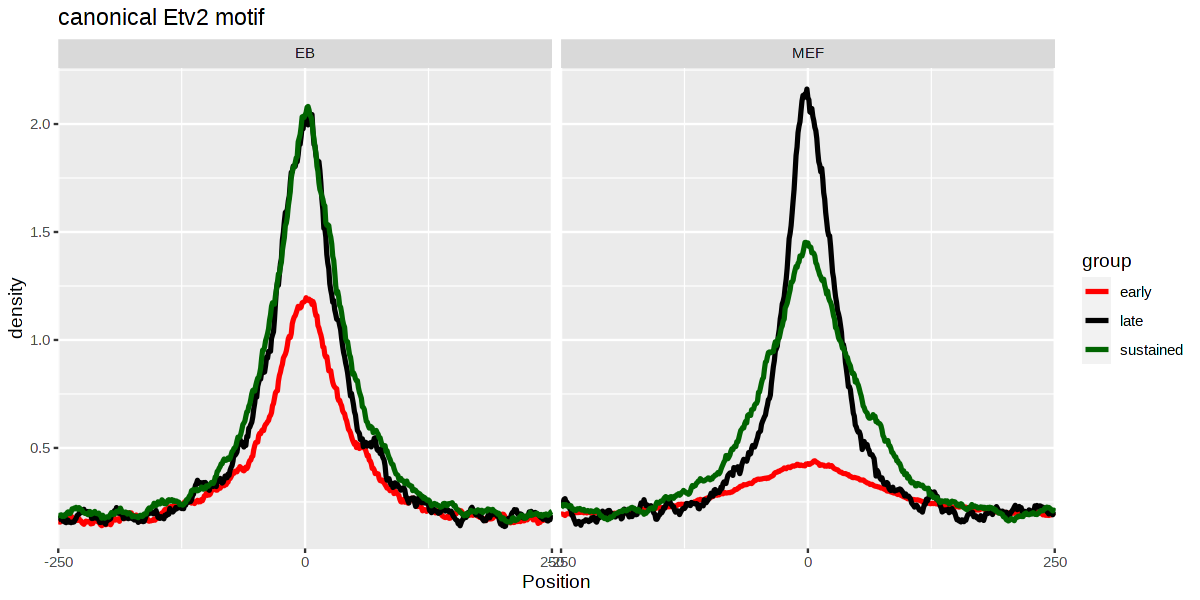

In [153]:
options(repr.plot.width = 10, repr.plot.height = 5)
rbind(
  cbind(df_MEF, cell = 'MEF'),
  cbind(df_EB, cell = 'EB')
) %>%
  filter(motif == 'canonical') %>% 
  ggplot(aes(x = position, y = density, color = group)) +
    geom_line(size = 1.1) +
    scale_x_continuous(name = 'Position', breaks = c(-250, 0, 250), expand = c(0, 0)) +
    scale_color_manual(values=c(early = "red", late = "black", sustained = 'darkgreen')) +
    facet_grid( ~cell) +
    ggtitle('canonical Etv2 motif')


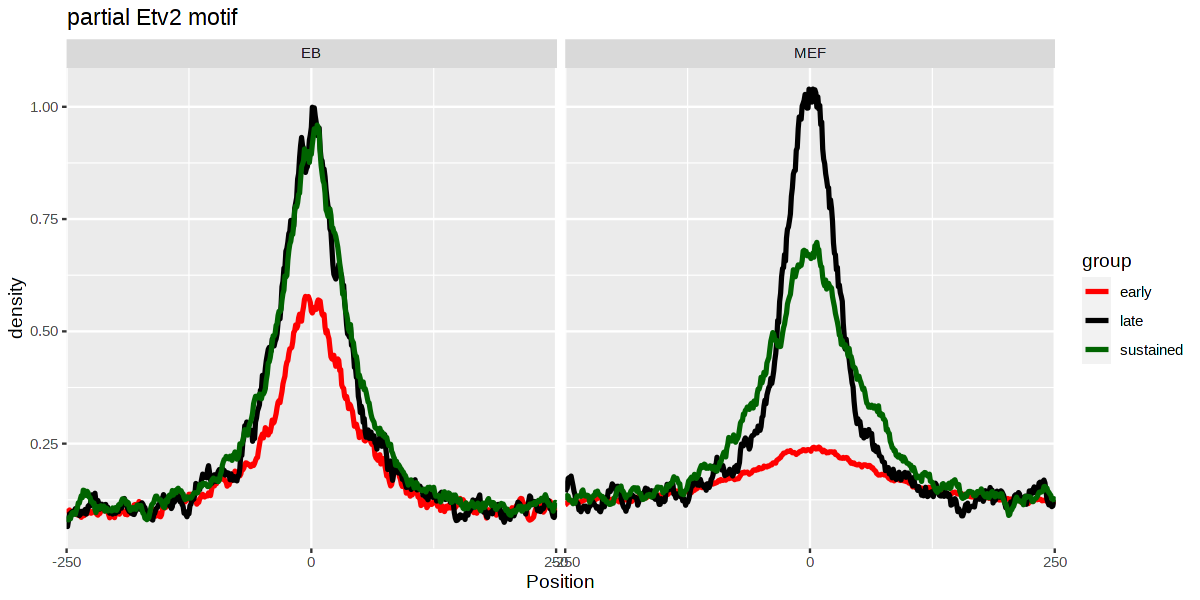

In [154]:
options(repr.plot.width = 10, repr.plot.height = 5)
rbind(
  cbind(df_MEF, cell = 'MEF'),
  cbind(df_EB, cell = 'EB')
) %>%
  filter(motif == 'partial') %>% 
  ggplot(aes(x = position, y = density, color = group)) +
    geom_line(size = 1.1) +
    scale_x_continuous(name = 'Position', breaks = c(-250, 0, 250), expand = c(0, 0)) +
    scale_color_manual(values=c(early = "red", late = "black", sustained = 'darkgreen')) +
    facet_grid(. ~ cell) +
    ggtitle('partial Etv2 motif')


In [155]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ggseqlogo_0.1                            
 [2] PWMEnrich.Dmelanogaster.background_4.24.0
 [3] PWMEnrich_4.26.0                         
 [4] TFBSTools_1.28.0                         
 [5] seqLogo_1.56.0                           

In [160]:
Sys.time() - start_time0

Time difference of 36.05479 secs